# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [1]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv


Bad key "text.kerning_factor" on line 4 in
D:\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [5]:
# Import the necessary CSVs to Pandas DataFrames
sfo_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(sfo_path, index_col="year")
coordinates_path = Path("./Data/neighborhoods_coordinates.csv")
neighborhood_coordinates = pd.read_csv(coordinates_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [40]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    mean_housing_units = sfo_data[["housing_units"]].groupby("year").mean()
    
    mean_housing_units_plot = mean_housing_units.plot(
        kind = 'bar', 
        title = 'Average Housing Units in San Francisco from 2010 to 2016',  
        ylim = (367500,388000), 
        yticks = ([370000, 372500, 375000, 377500, 380000, 382500, 385000, 387500])
    )
    
    return mean_housing_units_plot


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    mean_housing_costs = sfo_data.groupby("year").mean()
    mean_housing_costs.drop(columns = "housing_units", inplace = True)
    
    mean_gross_rent_plot = mean_housing_costs["gross_rent"].plot(
        title = "Average Gross Rent by Year", 
        color = 'red'
    )
    
    return mean_gross_rent_plot



def average_sales_price():
    """Average Sales Price Per Year."""
    
    mean_housing_costs = sfo_data.groupby("year").mean()
    mean_housing_costs.drop(columns = "housing_units", inplace = True)
    
    mean_sales_price_plot = mean_housing_costs["sale_price_sqr_foot"].plot(
        title = "Average Price per SqFt by Year"
    )
    
    return mean_sales_price_plot



def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    mean_values_df = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean().reset_index()
    
    mean_sales_price_by_neighborhood_plot = mean_values_df.hvplot(
        x = 'year', 
        y = 'sale_price_sqr_foot', 
        groupby = 'neighborhood', 
        xlabel = 'Year', 
        ylabel = 'Avg. Sale Price per Square Foot'
    )
    
    return mean_sales_price_by_neighborhood_plot



def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    expensive_neighborhoods_10 = sfo_data.groupby("neighborhood").mean().sort_values("sale_price_sqr_foot", ascending = False).reset_index().iloc[:10]

    expensive_neighborhoods_10_plot = expensive_neighborhoods_10.hvplot.bar(
        x = "neighborhood", 
        y = "sale_price_sqr_foot", 
        xlabel = "Neighborhood", 
        ylabel = "Avg. Sale Price per Square Foot", 
        title = "Top 10 Expensive Neighborhoods in SFO", 
        height = 400, rot = 90
    )
    
    return expensive_neighborhoods_10_plot

def compare_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices by Neighborhood."""   
    
    mean_values_df = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean().reset_index()
    
    compare_neighborhoods_plot = mean_values_df.hvplot.bar(
        x = "year", 
        y = ["gross_rent", "sale_price_sqr_foot"], 
        groupby = "neighborhood", 
        xlabel = "Year", 
        title = "Avg. Sale Price per Sqr Foot vs. Avg. Monthly Rent by Year", 
        rot = 90, 
        height = 400
    )
    
    return compare_neighborhoods_plot

    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""

    expensive_neighborhoods_10 = sfo_data.groupby("neighborhood").mean().sort_values("sale_price_sqr_foot", ascending = False).reset_index().iloc[:10]
    
    parallel_coordinates_expensive = px.parallel_coordinates(
        expensive_neighborhoods_10, 
        color = "sale_price_sqr_foot",
        title = "Parallel Coordinates Analysis of Most Expensive San Francisco Neighborhoods"
    )
    
    return parallel_coordinates_expensive



def parallel_categories():
    """Parallel Categories Plot."""
    
    expensive_neighborhoods_10 = sfo_data.groupby("neighborhood").mean().sort_values("sale_price_sqr_foot", ascending = False).reset_index().iloc[:10]

    parallel_categories_expensive = px.parallel_categories(
        expensive_neighborhoods_10, 
        dimensions = ["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"], 
        color = "sale_price_sqr_foot",
        title = "Parallel Categories Analysis of Most Expensive San Francisco Neighborhoods"
    )
    
    return parallel_categories_expensive
    
    

def neighborhood_map():
    """Neighborhood Map."""

    mean_values_neighborhood = sfo_data.groupby("neighborhood").mean().reset_index()
    neighborhood_values_df = pd.concat([neighborhood_coordinates, mean_values_neighborhood], axis = 1).drop(columns = "neighborhood")
    
    sf_neighborhood_map_plot = px.scatter_mapbox(
        neighborhood_values_df, 
        lat = "Lat", 
        lon = "Lon", 
        hover_name = "Neighborhood", 
        color = "gross_rent", 
        size = "sale_price_sqr_foot", 
        title = "Average Sale Price per Square Foot and Gross Rent in San Francisco"
    )
    
    return sf_neighborhood_map_plot


def sunburst():
    """Sunburst Plot."""
    
    mean_values_df = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean().reset_index()
    expensive_neighborhoods_10 = sfo_data.groupby("neighborhood").mean().sort_values("sale_price_sqr_foot", ascending = False).reset_index().iloc[:10]
    df_expensive_neighborhoods_per_year = mean_values_df[mean_values_df["neighborhood"].isin(expensive_neighborhoods_10["neighborhood"])]
    
    neighborhood_sunburst_plot = px.sunburst(
        df_expensive_neighborhoods_per_year, 
        path = ["year", "neighborhood"], 
        values = "sale_price_sqr_foot", 
        color = "gross_rent",
        title = "Costs Analysis of Most Expensive Neighborhoods in San Francisco"
    )
    
    return neighborhood_sunburst_plot


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [ ]:
# Create a Title for the Dashboard
# YOUR CODE HERE!


# Create a tab layout for the dashboard
# YOUR CODE HERE!


# Create the dashboard
# YOUR CODE HERE!

## Serve the Panel Dashboard

In [ ]:
# Serve the# dashboard
# YOUR CODE HERE!

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

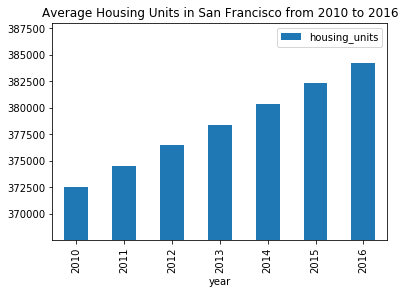

In [7]:
# housing_units_per_year()

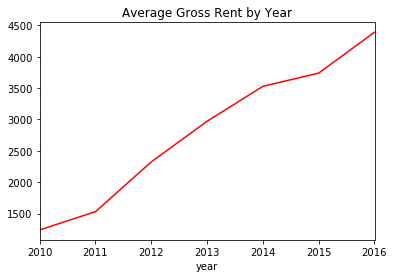

In [9]:
# average_gross_rent()

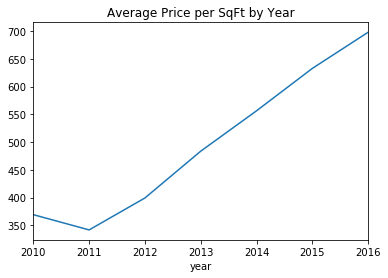

In [11]:
# average_sales_price()

In [46]:
average_price_by_neighborhood()

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

In [45]:
top_most_expensive_neighborhoods()

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [44]:
compare_neighborhoods_rent_sales()

:DynamicMap   [neighborhood]
   :Bars   [year,Variable]   (value)

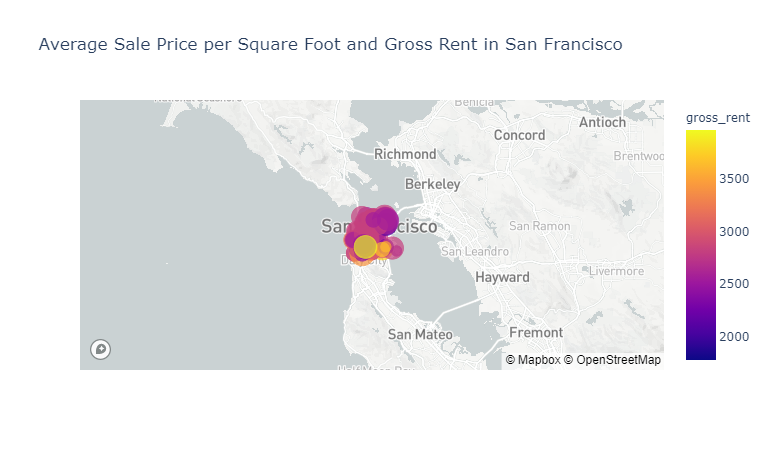

In [29]:
# neighborhood_map().show()

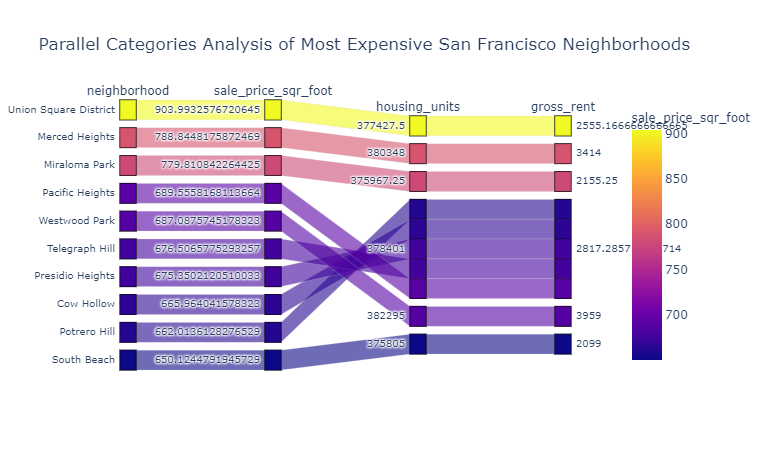

In [43]:
parallel_categories()

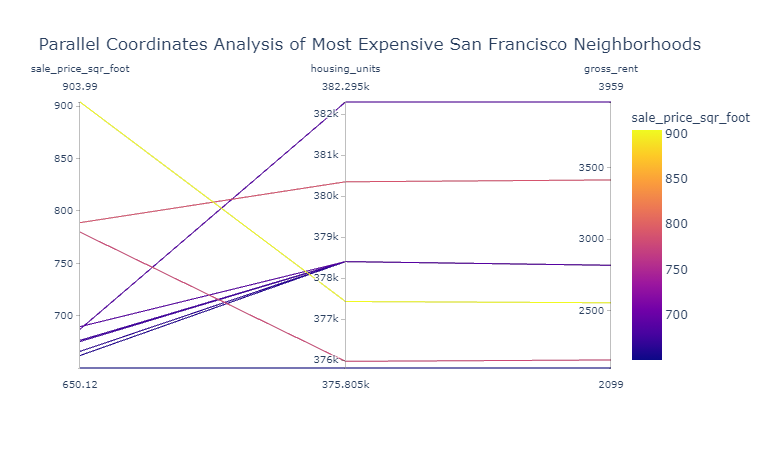

In [42]:
parallel_coordinates()

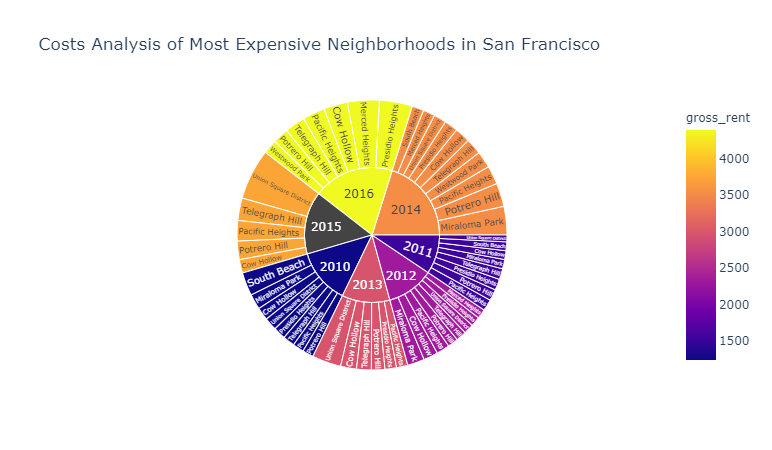

In [41]:
sunburst()